# DATA 512 Project Part 1

#### Preprocessing and Data Cleaning

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_us_cc = pd.read_csv("RAW_us_confirmed_cases.csv")
mask_use_by_county = pd.read_csv("mask-use-by-county.csv")
mask_mandates = pd.read_csv("us_public_mask_mandate.csv")
raw_cleaveland_cc = raw_us_cc[(raw_us_cc["Province_State"] == "Ohio") & (raw_us_cc["Admin2"] == "Cuyahoga")]

#first 12 columns are general info about the state
cleaveland_general_info = raw_cleaveland_cc[raw_cleaveland_cc.columns[0:12]]

CLEAVELAND_FIPS = cleaveland_general_info["FIPS"].values[0]

cleaveland_cc_by_date =  raw_cleaveland_cc[raw_cleaveland_cc.columns[12:]]
cleaveland_cc_by_date = pd.DataFrame(cleaveland_cc_by_date.iloc[0])
cleaveland_cc_by_date = cleaveland_cc_by_date.reset_index()
cleaveland_cc_by_date.columns = ["date", "cases"]
#use fips to narrow our other datasets when possible. CDC unfortunately breaks FIPS down by state and county so we cant use it here
cleaveland_mask_use = mask_use_by_county[mask_use_by_county["COUNTYFP"] == CLEAVELAND_FIPS]
cleaveland_mask_mandates = mask_mandates[(mask_mandates["State_Tribe_Territory"] == "OH") &\
     (mask_mandates['County_Name'] == 'Cuyahoga County')]
#lets set N/A values from before mandates came into effect to no. Technically people were not required to wear masks when covid did not exist in the state, no works here.
cleaveland_mask_mandates["Face_Masks_Required_in_Public"] = cleaveland_mask_mandates["Face_Masks_Required_in_Public"].fillna("No")

c:\Users\Michelle\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [172]:
#cleaveland_cc_by_date["date"] = cleaveland_cc_by_date['date'].astype(str)
cleaveland_cc_by_date["date"] = pd.to_datetime(cleaveland_cc_by_date["date"])
cleaveland_cc_by_date["daily"] = cleaveland_cc_by_date['cases'].diff().fillna(cleaveland_cc_by_date['cases'])

population = 1249387 #population from July 1, 2021 estimates

#calculate the 7 day moving average for cumulative case counts
cleaveland_cc_by_date['cases_rolling'] = cleaveland_cc_by_date.cases.rolling(window=7).mean().round()

#create a column for rolling average change in cases
cleaveland_cc_by_date['cases_rolling_delta'] = cleaveland_cc_by_date['cases_rolling'].diff()

#create a column for population at risk
cleaveland_cc_by_date['population_at_risk'] = (population - cleaveland_cc_by_date['cases_rolling'])

#create a column for infection rate (each infection is 14 days)
cleaveland_cc_by_date['infection_rate'] = cleaveland_cc_by_date['cases_rolling_delta'].rolling(min_periods=1, window=14).sum() / cleaveland_cc_by_date['population_at_risk']

#create a column for change in infection rate as a percent
cleaveland_cc_by_date['infection_rate_delta'] = 100*(cleaveland_cc_by_date['infection_rate'].diff())


Finding the start and end dates of the mask mandate

In [193]:
mask_start = list(cleaveland_mask_mandates.loc[cleaveland_mask_mandates["Face_Masks_Required_in_Public"]=="Yes"]["date"].head(1))[0]
mask_end = list(cleaveland_mask_mandates.loc[cleaveland_mask_mandates["Face_Masks_Required_in_Public"]=="Yes"]["date"].tail(1))[0]


Plotting the daily cases vs. total cases

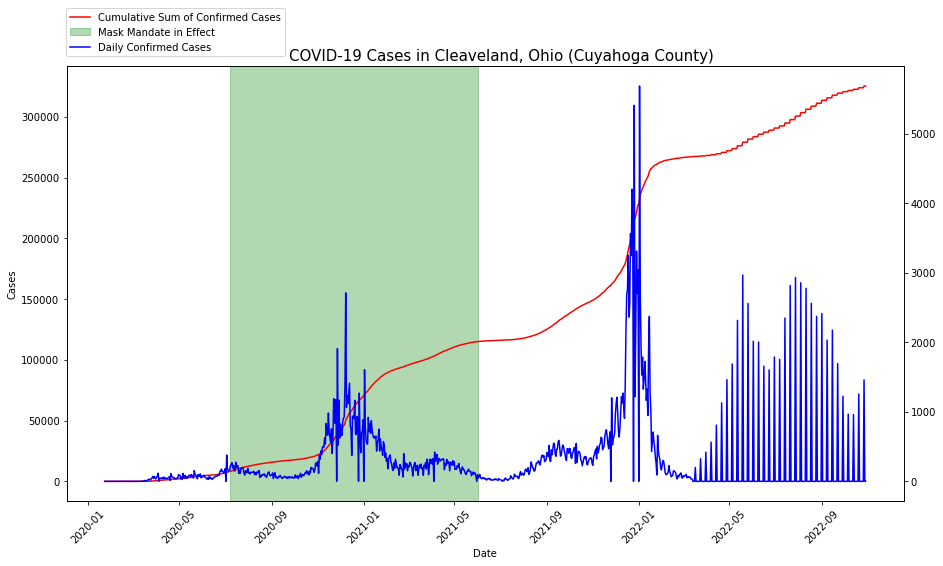

In [196]:
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
import datetime as dt
from datetime import datetime

fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.xticks(rotation = 45)
ax2 = ax1.twinx()

ax1.plot(cleaveland_cc_by_date["date"], cleaveland_cc_by_date["cases"], 'r-', label = "Cumulative Sum of Confirmed Cases")

ax2.plot(cleaveland_cc_by_date["date"], cleaveland_cc_by_date["daily"], "b-", label = "Daily Confirmed Cases")
ax1.axvspan(datetime.strptime(mask_start, '%m/%d/%Y'), datetime.strptime(mask_end, '%m/%d/%Y'), 
            label="Mask Mandate in Effect",color="green", alpha=0.3) # creates the mask mandate shading
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes] # getting label names for legend
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


ax1.set_xlabel('Date')
ax1.set_ylabel('Cases')

fig.legend(lines, labels, loc = (0.07, 0.9), ncol=1)
plt.title("COVID-19 Cases in Cleaveland, Ohio (Cuyahoga County)", fontsize=15, x = 0.52)
plt.show()

Plotting the Change in Rate of Infection

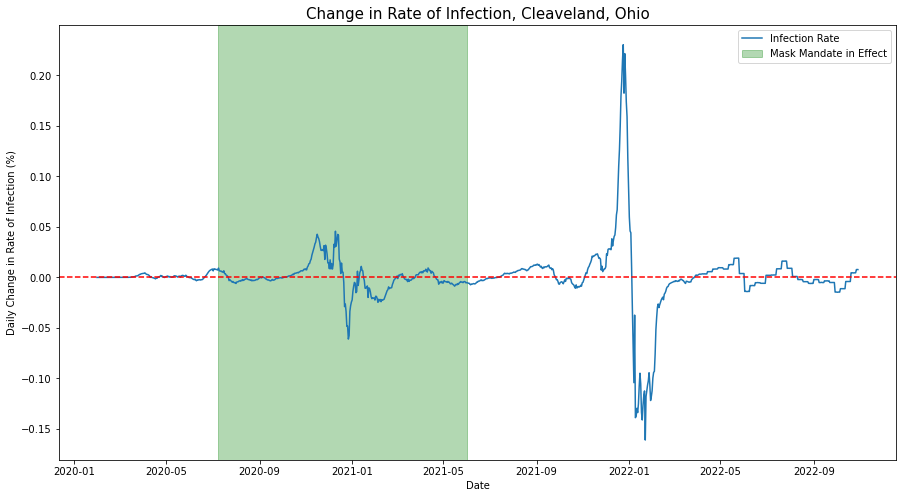

In [197]:
x = cleaveland_cc_by_date['date']
y = cleaveland_cc_by_date['infection_rate_delta']
#c = combined['order_code']

#create figure and subplot
fig, ax = plt.subplots(figsize=(15, 8))

#add title
plt.title('Change in Rate of Infection, Cleaveland, Ohio', fontsize=15)
plt.ylabel('Daily Change in Rate of Infection (%)')
plt.xlabel('Date')

#scatter = ax.scatter(x, y)
line = ax.plot(x, y, '-', label='Infection Rate')

#horizontal at 0 rate of change
plt.axhline(y=0, linestyle='--', color = "r")

plt.axvspan(datetime.strptime(mask_start, '%m/%d/%Y'), datetime.strptime(mask_end, '%m/%d/%Y'), 
            label="Mask Mandate in Effect",color="green", alpha=0.3)
plt.legend()
plt.show()